# 分類器の学習

これまで，ニューラルネットワークの定義の仕方，損失の計算，パラメータの更新についてざっくりみてきました。

ここまできたら，次に考えるべきことは：

## 何のデータを取り扱うの？

一般に，画像，テキスト，音声，ビデオなどのデータを処理するとき，それらに対応したPythonの標準的なパッケージを使って`numpy`配列にデータを読み込むことができます。そしてこのnumpy配列を`torch.*Tensor`に変換することができます。

扱うデータによって，下記のようなパッケージがあります：

- 画像：Pillow, OpenCV
- 音声：scipy, librosa
- テキスト：NLTK, SpaCy

画像に関して，`vision`というパッケージがありますが，これを`torchvision`としてPyTorchチームは新しく作り変えました。これによって，ImageNetやCIFAR10，MNISTなどの標準となっているデータセットを読み込んだり，データ変換などの機能を持ちます。これらは，`torchvision.datasets`，`torch.utils.data.DataLoader`に入っています。

`torchvision`にはこうした高次の実装が行われているので，新しくコードを書く必要がなく，とても便利です。

このチュートリアルでは，CIFAR10データセットを使います。

CIFAR10には，下記の10クラスがあります：
```
‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck'
```

CIFAR10に含まれる画像サイズは 3x32x32 つまり，3つのカラーチャンネルを持つ32x32のピクセルからなります。

![http://pytorch.org/tutorials/_images/cifar10.png](http://pytorch.org/tutorials/_images/cifar10.png)
cifar10

## 画像分類器の学習

CIFAR10を用いた画像分類器の訓練のために，下記の工程を順に行います。

- 1. 学習用画像とテスト用画像を読み込み，正規化する。このとき，`torchvision`を使う。
- 2. 畳み込みニューラルネットワークを定義する。
- 3. 損失関数を定義する。
- 4. 学習用画像を用いて学習する。
- 5. テスト用画像を用いてテストする。

### 1. CIFAR10の読み込みと正規化

`torchvision`を使えば，CIFAR10の読み込みはとても簡単にできます。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision に含まれるデータセットはPILImageで，$[0,1]$のレンジを持ちます。これを，$[-1,1]$に正規化したテンソルに変換します。

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


試しに，データセットに含まれている画像がどんなものなのか見てみましょう。

 deer  bird plane truck


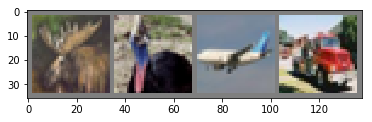

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 畳み込みニューラルネットワークを定義する